# SelectQA: Regression Test Case Selection Using Quantum Annealing
Regression testing is an important part of the software development process in software engineering. It is a practice aimed at identifying any regression, which are the emergence of new defects or issues in a software application following changes, enhancements, or updates made to the source code. In other words, regression testing focuses on how changes made to the software can affect the correct behavior of existing features. Regression testing is particularly important in agile software development environments, where changes are made frequently and rapidly. This practice helps ensure that the software remains stable and reliable as it evolves over time. Ideal regression testing would re-run all the available test cases of a given software system. However, in addition to being potentially very costly, this could even be impractical in some case. In this scenario, test case selection is one of the most widely investigated test suite optimization approaches.
Test case selection focuses on selecting a subset from an initial test suite to test software changes, i.e., to test whether unmodified parts of a program continue to work correctly after changes involving other parts. Various techniques, such as Integer Programming, symbolic execution, data flow analysis, dependence graph-based methods, and flow graph-based approaches, can be employed to identify the modified portions of the software. Once test cases covering the unchanged program segments are pinpointed using a specific technique, an optimization algorithm (e.g., additional greedy, DIV-GA,
SelectQA, or BootQA) can select a minimal set of these test cases based on certain testing criteria (e.g., branch coverage). The ultimate aim is to reduce the expenses associated with regression testing.

In [1]:
#this cell contains all the imports needed by the pipeline
#to run it on the browser: jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10
import json
import time

from dwave.system import LeapHybridSampler
import dimod
import matplotlib.pyplot as plt
import random
import numpy as np
import statistics
import csv
import pandas as pd
from scipy.stats import mannwhitneyu, shapiro

In [2]:
#this is the constant that represent the number of experiments' iterations
tot_run = 10

## The pipeline dataset
To experiment the performance of the proposed solution by this work and to compare its results to those of state-of-the-art solutions, 4 public programs have been downloaded from the SIR website. SIR is a repository of software-related artifacts meant to support rigorous controlled experimentation with program analysis and software testing techniques, and education in controlled experimentation. 

### Chosen SIR Programs
The programs that will be used for experimentation have all been written in C and are:
- flex (a program that generates a lexical analysis program, based on regular expressions and C statement contained in one or more input files);
- grep (a useful program to search form matching patterns in a file);
- gzip (a program that substitute a file, generally text files or web pages, with their compressed version)
- sed (a powerful program for stream text editing).

### Needed information
The information needed by the quantum algorithm to work on every one of the 4 programs are:
- a fault matrix: it indicates whether a precise test case already found, during previous execution, a bug in the source code or not;
- execution cost: it indicates the execution cost of any test case of the suite;
- statement coverage: it indicates statement coverage information for every test case. 

All this information have been gathered through previous experimentation on the four programs mentioned above and written in files organized in the SIR_Programs folder. So, the first goal of the project will be gathering data from these files for computational purposes.

In [39]:
#this cell contains all variable definitions that will be useful throughout the entire project
sir_programs = ["flex","grep","gzip","sed"]
sir_programs_tests_number = {"flex":567,"grep":806,"gzip":214,"sed":360}
sir_programs_end_lines = {"flex":14192,"grep":13281,"gzip":6701,"sed":7118}
alpha = 0.5

In [31]:
#let's make a function to read the fault matrices
#IMPORTANT: all the fault-matrix files must be renamed as "fault-matrix".txt and must be written using the same standard used by the files of this project (i-th line->e0e1e2e3..., where ej is 0 if the i-th test found a bug when launched on the j-th version)
def get_fault_list(program_name:str):
    """This function opens the fault-matrix file of a sir programs and makes a list of binary values for each test case of that program to indicate whether a test case found or not a bug in at least one of the available versions of the program"""
    #open the fault-matrix file of the desired SIR program
    program_file = open("SIR_Programs/"+program_name+"/fault-matrix.txt")
    lines = program_file.readlines()
    
    #we need a list which elements represent test cases, the i-th element is 1 if the i-th test case
    #discovered a fault in the past, 0 otherwise
    faults_test_by_test = list()
    
    i = 0
    for line in lines:
        if "1" in line:
            faults_test_by_test.append(1)
        else:
            faults_test_by_test.append(0)
        i += 1
    
    program_file.close()
    
    return faults_test_by_test

In [32]:
#the next function is able to research into the json coverage information file of each test case
#of each sir program to gather information about the single test cases costs and coverage
def cost_and_coverage_information_gathering(program_name:str):
    """The aim of this function is to obtain a dictionary that for each test case of a program indicates its cost, and a dictionary that, for each code line of the program to test, makes a list of all the test cases that run that line"""
    test_case_execution_cost = 0
    
    execution_cost_test_by_test = dict()
    executed_lines_test_by_test = dict()
    lines_of_tests_list = dict()
    total_file_lines = 0
    read_files = []
    
    for test_case in range(sir_programs_tests_number[program_name]):
        #to open the correct file, we must remember that the folders and the json files are
        #numbered from 1 and not from 0
        if program_name == "gzip":
            json_name = "allfile"
        else:
            json_name = program_name
        test_case_json = open("SIR_Programs/"+program_name+"/json_"+program_name+"/t"+str(test_case+1)+"/"+json_name+str(test_case+1)+".gcov.json")
        
        #read the JSON object as a dictionary
        json_data = json.load(test_case_json)
        
        # to have coverage % we will need the total number of lines to cover
        for file in json_data["files"]:
            if file["file"] not in read_files:
                total_file_lines += len(file["lines"])
                read_files.append(file["file"])
        
        #for programs tested above more than one file, the initial row of a file will start from
        #the final row of the preceding file
        i = 0
        for file in json_data["files"]:
            line_count_start = i
            for line in file["lines"]:
                #if a line is executed, we want to remember FOR THAT LINE which are the tests
                #that executed it, and we want to increment the execution cost
                if line["unexecuted_block"] == False:
                    #the test suite exec cost = sum of the exec freq. of each executed basic block
                    #by each test case
                    #test_suite_execution_cost += line["count"]
                    test_case_execution_cost += line["count"]
                    
                    if (line_count_start + line["line_number"]) not in executed_lines_test_by_test:
                        executed_lines_test_by_test[line_count_start + line["line_number"]] = [test_case]
                    else:
                        executed_lines_test_by_test[line_count_start + line["line_number"]].append(test_case)
                    executed_lines_test_by_test[line_count_start + line["line_number"]].sort()
                    
                    if test_case not in lines_of_tests_list:
                        lines_of_tests_list[test_case] = [line_count_start + line["line_number"]]
                    else:
                        lines_of_tests_list[test_case].append(line_count_start + line["line_number"])
                    lines_of_tests_list[test_case].sort()
                i = line["line_number"]
        
        #saving the total amount of execution cost for this test case and resetting for the next
        execution_cost_test_by_test[test_case] = test_case_execution_cost
        test_case_execution_cost = 0
        
        test_case_json.close()
                        
    return execution_cost_test_by_test, executed_lines_test_by_test, lines_of_tests_list, total_file_lines
                    

In [33]:
#we can now gain all the historical information about past fault detection 
faults_dictionary = {"flex": None, "grep": None, "gzip": None, "sed": None}

for sir_program in sir_programs:
    faults_dictionary[sir_program] = (get_fault_list(sir_program))
    
print(faults_dictionary)

{'flex': None, 'grep': None, 'gzip': None, 'sed': [1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [34]:
#we can now gain costs and coverage information

test_cases_costs = {"flex":None,"grep":None,"gzip":None,"sed":None}
coverage = {"flex":None,"grep":None,"gzip":None,"sed":None}
lines_of_tests_list = {"flex":None,"grep":None,"gzip":None,"sed":None}
total_file_lines = {"flex":None,"grep":None,"gzip":None,"sed":None}

for sir_program in sir_programs:
    costs_and_coverage = cost_and_coverage_information_gathering(sir_program)
    test_cases_costs[sir_program] = costs_and_coverage[0]
    coverage[sir_program] = costs_and_coverage[1]
    lines_of_tests_list[sir_program] = costs_and_coverage[2]
    total_file_lines[sir_program] = costs_and_coverage[3]

print(test_cases_costs)
print(lines_of_tests_list)
print(total_file_lines)

{'flex': None, 'grep': None, 'gzip': None, 'sed': {0: 104, 1: 104, 2: 68, 3: 52, 4: 99, 5: 58504, 6: 59629, 7: 56861, 8: 33672, 9: 34663, 10: 99, 11: 99, 12: 6931, 13: 28, 14: 28, 15: 35787, 16: 4931, 17: 2749, 18: 51593, 19: 26885, 20: 6616, 21: 49947, 22: 49992, 23: 50067, 24: 50125, 25: 51114, 26: 114657, 27: 262595, 28: 43395, 29: 131263, 30: 143727, 31: 1811, 32: 3691, 33: 35039, 34: 3763, 35: 81274, 36: 31753, 37: 29695, 38: 29695, 39: 31596, 40: 32284, 41: 32104, 42: 29196, 43: 32449, 44: 8882, 45: 8205, 46: 8574, 47: 8574, 48: 22932, 49: 108834, 50: 7881, 51: 98752, 52: 51613, 53: 51204, 54: 49750, 55: 51330, 56: 59365, 57: 59286, 58: 59276, 59: 33759, 60: 62276, 61: 62318, 62: 62313, 63: 62350, 64: 30379, 65: 30646, 66: 30631, 67: 30646, 68: 4441, 69: 4824, 70: 4819, 71: 4824, 72: 184061, 73: 184398, 74: 184313, 75: 184388, 76: 52273, 77: 52666, 78: 29696, 79: 32245, 80: 29472, 81: 31871, 82: 29472, 83: 31808, 84: 33956, 85: 34320, 86: 32460, 87: 31795, 88: 31145, 89: 31815, 9

## Additional Greedy
One of the classical strategies generally used to solve the test case selection problem is the "Additional Greedy" approach. This strategy is applied using the standard weighted sum approach to conflate all the objectives to optimize the weighted sum of code coverage per unit time and fault coverage per unit time. This way, a list of non dominated solutions is built incrementally.

In [ ]:
def lines_to_cover(sir_program):
    """This function is needed to know which are the lines that have to be covered."""
    lines_to_cover = set()
    
    for covered_lines in lines_of_tests_list[sir_program].values():
        for covered_line in covered_lines:
            lines_to_cover.add(covered_line)
            
    return lines_to_cover

def additional_greedy(sir_program):
    """This functions implements the Additional Greedy algorithm. It incrementally builds a set of non dominated solutions, choosing each time the test case that minimize the function described earlier."""
    c = set()
    p = lines_to_cover(sir_program)
    s = []
    pareto_front = []
    test_cases_already_selected = []
    while len(c) < len(p):
        weighted_sum = {}
        for test_case in range(0,sir_programs_tests_number[sir_program]):
            if test_case not in test_cases_already_selected and test_case in lines_of_tests_list[sir_program].keys():
                max_cost = max(test_cases_costs[sir_program].values())
                added_coverage = [line for line in lines_of_tests_list[sir_program][test_case] if line not in c]
                weighted_sum[test_case]=((0.5 * (len(added_coverage)/len(lines_of_tests_list[sir_program][test_case]))) + (0.5 * faults_dictionary[sir_program][test_case]))/(test_cases_costs[sir_program][test_case]/max_cost)
        # take the test case that minimize the function
        best_test_case = min(weighted_sum,key=weighted_sum.get)
        test_cases_already_selected.append(best_test_case)
        for covered_line in lines_of_tests_list[sir_program][best_test_case]:
            # update the count of covered lines
            c.add(covered_line)
        s.append(best_test_case)
        # incremental building of the pareto frontier
        pareto_front.append(s.copy())
    
    return pareto_front

# running the greedy algorithm and saving the resulting solutions with execution times into .json files 
for sir_program in sir_programs:
    with open(f"results/add-greedy/{sir_program}_data.json", "w") as file:
        json_data = {}
        start = time.time()
        json_data["pareto_front"] = additional_greedy(sir_program)
        end = time.time()
        json_data["resolution_time(ms)"] = (end-start)*1000
        json.dump(json_data,file)

## Quantum Annealing
Quantum annealing is a quantum computing technique used by D-Wave Systems, and it's designed to solve combinatorial optimization problems.

Quantum annealing leverages the principles of quantum mechanics to search for optimal or approximate solutions to optimization problems. It relies on a gradual transition from an initial state to a final state through a process known as "annealing." During this transition, the system aims to minimize an objective function, which must be formulated in a way that can be tackled by the quantum annealer. This involves translating the problem into a mathematical form known as "Quadratic Unconstrained Binary Optimization" (QUBO), which is suitable for representation on a quantum computer.

D-Wave's quantum annealer uses quantum qubits to simultaneously explore different combinations of variable values, seeking the optimal solution. During the annealing process, transition probabilities between quantum states are adjusted to minimize the objective function. At the end of the annealing process, a solution is obtained, representing a potential assignment of values to the problem's variables while aiming to minimize the objective function.

## QUBO Problems
A Quadratic Unconstrained Binary Optimization (QUBO) problem is a type of mathematical problem where we seek to find the best combination of binary values (0 or 1) for a set of variables to minimize or maximize an objective function. In other words, we are looking for the optimal solution among all possible variable combinations that satisfies certain constraints and makes the objective function as small as possible.

Weights for constraints (or penalty coefficients) are used in QUBO problems to assign a numerical value to the constraints and influence the optimization process. These weights are important because they allow for managing the priority and relative importance of constraints within the optimization problem.

In [ ]:
def create_adjvector_bqm(sir_program, alpha, P):
    """This function is the one that has to encode the QUBO problem that the D-Wave Hybrid Sampler will have to solve. The QUBO problem specifies the optimization to solve and a quadratic binary unconstrained problem"""
    qubo = dimod.AdjVectorBQM(dimod.BINARY)
    max_cost = max(test_cases_costs[sir_program].values())

    #linear coefficients, that are the diagonal of the matrix encoding the QUBO
    for i in range(sir_programs_tests_number[sir_program]):
        cost = (alpha * (test_cases_costs[sir_program][i]/max_cost)) - (1 - alpha) * faults_dictionary[sir_program][i]
        qubo.set_linear(i, cost)

    #quadratic coefficient, that are the lower part of the QUBO matrix
    for k in coverage[sir_program].keys():
        test_cases = coverage[sir_program][k]
        for i in test_cases:
            for j in test_cases:
                if i < j:
                    qubo.set_linear(i,qubo.linear[i]-P)
                    qubo.set_linear(j,qubo.linear[j]-P)
                    try:
                        qubo.set_quadratic(i, j,qubo.quadratic[i,j] + 2 * P)
                    except:
                        qubo.set_quadratic(i, j, 2 * P)

    return qubo


In [ ]:
penalties_dictionary = {"flex":None,"grep":None,"gzip":None,"sed":None}

#to obtain a QUBO problem from a quadratic problem with constraints, we have to insert those constraints into the Hamiltonian to solve (which is the one encoded by the QUBO problem). When we insert constraint into the Hamiltonian, we have to specify also penalties
for sir_program in sir_programs:
    max_penalty = 0
    max_cost = max(test_cases_costs[sir_program].values())
    for i in range(sir_programs_tests_number[sir_program]):
        cost = (alpha * (test_cases_costs[sir_program][i]/max_cost)) - ((1 - alpha) * faults_dictionary[sir_program][i])
        if cost > max_penalty:
            max_penalty = cost
    penalties_dictionary[sir_program] = max_penalty + 1

In [ ]:
qubos_dictionary = {"flex":None,"grep":None,"gzip":None,"sed":None}

#make a dictionary that saves, for each program, the correspondent QUBO
for sir_program in sir_programs:
    qubos_dictionary[sir_program] = create_adjvector_bqm(sir_program,alpha,penalties_dictionary[sir_program])

In [ ]:
def get_stmt_coverage(sir_program,test_cases_list):
    covered_lines = set()
    
    for test_case in test_cases_list:
        try:
            for covered_line in lines_of_tests_list[sir_program][test_case]:
                covered_lines.add(covered_line)
        except:
            continue
    
    return len(covered_lines)

def build_pareto_front(sir_program,selected_tests):
    pareto_front = []
    max_fault_coverage = 0
    max_stmt_coverage = 0
    
    for index in range(1,len(selected_tests)+1):
        #exract the first index selected tests
        candidate_solution = selected_tests[:index]
        candidate_solution_fault_coverage = 0
        candidate_solution_stmt_coverage = 0
        for selected_test in candidate_solution:
            candidate_solution_fault_coverage += faults_dictionary[sir_program][selected_test]
            candidate_solution_stmt_coverage += get_stmt_coverage(sir_program,candidate_solution)
        #if the actual pareto front dominates the candidate solution, get to the next candidate
        if max_fault_coverage >= candidate_solution_fault_coverage and max_stmt_coverage >= candidate_solution_stmt_coverage:
            continue
        #eventually update the pareto front information
        if candidate_solution_stmt_coverage > max_stmt_coverage:
            max_stmt_coverage = candidate_solution_stmt_coverage
        if candidate_solution_fault_coverage > max_fault_coverage:
            max_fault_coverage = candidate_solution_fault_coverage
        #add the candidate solution to the pareto front
        pareto_front.append(candidate_solution)
    
    return pareto_front

In [ ]:
#old (original) sampling cell
sampler = LeapHybridSampler(token="")

#I want to run the sampler 30 times to obtain different results for each sir program
for sir_program in sir_programs:
    #the fronts will be saved into files
    print(sir_program)
    file_path = "results/selectqa/" + sir_program + "-data.json"
    json_data = {}
    response = None
    qpu_run_times = []
    pareto_fronts_building_times = []
    for i in range(10):
        print(str(i))
        #for each iteration get the result
        response = sampler.sample_qubo(qubos_dictionary[sir_program].to_numpy_matrix())
        #sample_dictionary is like {0:0,1:0,2:1,3:1,4:1,5:0,....}
        sample_dictionary = {i: response.samples()[0][i] for i in range(len(response.samples()[0]))}
        qpu_run_times.append(response.info["run_time"])
        #let's extract the selected tests
        selected_tests = [test_case for test_case, x_val in sample_dictionary.items() if x_val == 1]
        #now we have to build the pareto front
        start = time.time()
        pareto_front = build_pareto_front(sir_program,selected_tests)
        end = time.time()
        json_data["pareto_front_"+str(i)] = pareto_front
        pareto_front_building_time = (end-start)*1000
        pareto_fronts_building_times.append(pareto_front_building_time)
    
    #compute the average time needed for the construction of a pareto frontier and run time
    mean_qpu_run_time = statistics.mean(qpu_run_times)
    mean_pareto_fronts_building_time = statistics.mean(pareto_fronts_building_times)
    json_data["mean_qpu_run_time(ms)"] = mean_qpu_run_time
    json_data["mean_pareto_fronts_building_time(ms)"] = mean_pareto_fronts_building_time
    
    with open(file_path,"w") as file:
        json.dump(json_data,file)

## Empirical Evaluations
From the pareto fronts obtained on 10 different repetitions (for each programme under examination), the non-dominated samples were extrapolated. In this way, for each repetition of each program, a reference front was constructed to allow comparison between the algorithms: quantum annealing, additional greedy and DIV-GA.
For each algorithm, divided by programmes, the average number (and std. dev.) of samples in their pareto fronts was calculated. Likewise, the average number (and std. dev.) of samples from their own front present in the reference front was also calculated.
The latter metric was subjected to the Mann-Whitney's statistical U test and then to the Vargha-Delaney's $\hat{A}_{12}$ effect size calculation to establish its validity and statistical magnitude.

Also, the execution times of the three different algorithms were stored and confronted. Since the classical and quantum components of the D-Wave's hybrid solver work synchronously, the only metric available for such a comparison was the total "run-time".

In [ ]:
#the other sizes are uniform
#this static information can be easily obtained from the pareto .json files

qtcs_flex_pareto_sizes = [284,283,284,283,284,284,284,283,284,283]
divga_flex_pareto_sizes = [140,140,140,140,140,140,140,140,140,140]
greedy_flex_size = 567

qtcs_grep_pareto_sizes = [402,402,403,403,403,402,403,403,402,404]
divga_grep_pareto_sizes = [70,70,70,70,70,70,70,70,70,70]
greedy_grep_size = 802

qtcs_gzip_pareto_sizes = [107,107,108,107,107,106,107,107,108,108]
divga_gzip_pareto_sizes = [105,105,105,105,105,105,105,105,105,105]
greedy_gzip_size = 199

qtcs_sed_pareto_sizes = [180,180,180,180,180,180,180,180,180,180]
divga_sed_pareto_sizes = [105,62,105,105,102,105,105,97,105,105]
greedy_sed_size = 356

In [35]:
def total_cost(sir_program,solution):
    solution_cost = 0
    
    for test_case in solution:
        solution_cost += test_cases_costs[sir_program][test_case]

    return solution_cost
        
def total_coverage(sir_program,solution):
    covered_lines = set()
    
    for test_case in solution:
        try:
            for covered_line in lines_of_tests_list[sir_program][test_case]:
                covered_lines.add(covered_line)
        except:
            continue
    
    return len(covered_lines)
    
def total_faults(sir_program,solution):
    covered_faults = 0
    
    for test_case in solution:
        covered_faults += faults_dictionary[sir_program][test_case]
    
    return covered_faults

def pareto_dominance(tuple1, tuple2):
    # Check if all conditions are satisfied
    dominates = (
        (tuple2[0] <= tuple1[0]) and 
        (tuple2[1] >= tuple1[1]) and 
        (tuple2[2] >= tuple1[2])
    )
    
    # Check if at least one condition is strict
    strict = (
        (tuple2[0] < tuple1[0]) or 
        (tuple2[1] > tuple1[1]) or 
        (tuple2[2] > tuple1[2])
    )
    
    # Return 1 if the second tuple dominates the first, otherwise 0
    return 1 if dominates and strict else 0

In [36]:
with open('.\\results\\add-greedy\\sed_data.json', 'r') as file:
    pareto_fronts_json = json.load(file)
    
greedy_pareto_front = pareto_fronts_json['pareto_front']
greedy_pareto_vectors = []
for front_solution in greedy_pareto_front:
    greedy_pareto_vectors.append((total_cost("sed",front_solution),total_coverage("sed",front_solution),total_faults("sed",front_solution)))
print(len(greedy_pareto_vectors))

356


In [37]:
qtcs_pareto_vectors = []
divga_pareto_vectors = []

for index in range(0,10):
    # Load the JSON file
    with open('.\\results\\selectqa\\sed-data.json', 'r') as file:
        pareto_fronts_json = json.load(file)
    
    qtcs_pareto_front = pareto_fronts_json['pareto_front_'+str(index)]
    for front_solution in qtcs_pareto_front:
        qtcs_pareto_vectors.append((total_cost("sed",front_solution),total_coverage("sed",front_solution),total_faults("sed",front_solution)))
    #print(len(qtcs_pareto_vectors))
    
    with open('.\\results\\divga\\sed_pareto_fronts_divga.json', 'r') as file:
        pareto_fronts_json = json.load(file)
    
    divga_pareto_front = pareto_fronts_json['sed_pareto_front_'+str(index)]
    for front_solution in divga_pareto_front:
        divga_pareto_vectors.append((total_cost("sed",front_solution),total_coverage("sed",front_solution),total_faults("sed",front_solution)))
    #print(len(divga_pareto_vectors))

# once the three different pareto frontiers have been built, they can be merged in one only frontier to extract the reference one
total_fronts = [qtcs_pareto_vectors,divga_pareto_vectors,greedy_pareto_vectors]
reference_pareto = []
portions = [0,0,0]

# get the reference frontier
for index, front1 in enumerate(total_fronts):
    for front_solution1 in front1:
        is_dominated = 0
        other_fronts = total_fronts[:index] + total_fronts[index+1:]
        for front2 in other_fronts:
            for front_solution2 in front2:
                if pareto_dominance(front_solution1,front_solution2):
                    is_dominated = 1
                    break
            if is_dominated:
                break
        if not is_dominated:
            reference_pareto.append(front_solution1)
            portions[index] = portions[index] + 1

print(portions)

[1084, 996, 80]


In [74]:
# For each of the algorithms we want the average of solutions that are in the reference pareto frontier

qtcs_non_dominated_values = []
divga_non_dominated_values = []
greedy_non_dominated = 0

for index in range(0,10):
    #print("Iterazione: " + str(index))
    
    qtcs_non_dominated = 0
    divga_non_dominated = 0
    
    # Load the JSON file
    with open('.\\results\\selectqa\\sed-data.json', 'r') as file:
        pareto_fronts_json = json.load(file)
    
    qtcs_pareto_front = pareto_fronts_json['pareto_front_'+str(index)]
    for front_solution in qtcs_pareto_front:
        if (total_cost("sed",front_solution),total_coverage("sed",front_solution),total_faults("sed",front_solution)) in reference_pareto:
            qtcs_non_dominated += 1
    
    qtcs_non_dominated_values.append(qtcs_non_dominated)
    #print(qtcs_non_dominated)
    
    with open('.\\results\\divga\\sed_pareto_fronts_divga.json', 'r') as file:
        pareto_fronts_json = json.load(file)
    
    divga_pareto_front = pareto_fronts_json['sed_pareto_front_'+str(index)]
    for front_solution in divga_pareto_front:
        if (total_cost("sed",front_solution),total_coverage("sed",front_solution),total_faults("sed",front_solution)) in reference_pareto:
            divga_non_dominated += 1
            
    divga_non_dominated_values.append(divga_non_dominated)
    #print(divga_non_dominated)
    
for front_solution in greedy_pareto_front:
    if (total_cost("sed",front_solution),total_coverage("sed",front_solution),total_faults("sed",front_solution)) in reference_pareto:
        greedy_non_dominated += 1
print(greedy_non_dominated)

print("QTCS/DIVGA/ADD GREEDY")
print(qtcs_non_dominated_values)
print(statistics.mean(qtcs_non_dominated_values))
print(statistics.stdev(qtcs_non_dominated_values))
print(statistics.mean(divga_non_dominated_values))
print(statistics.stdev(divga_non_dominated_values))
print(divga_non_dominated_values)
print(greedy_non_dominated)

80
QTCS/DIVGA/ADD GREEDY
[104, 123, 110, 105, 110, 110, 115, 101, 107, 99]
108.4
6.995236474439826
99.6
13.459403982181215
[105, 62, 105, 105, 102, 105, 105, 97, 105, 105]
80


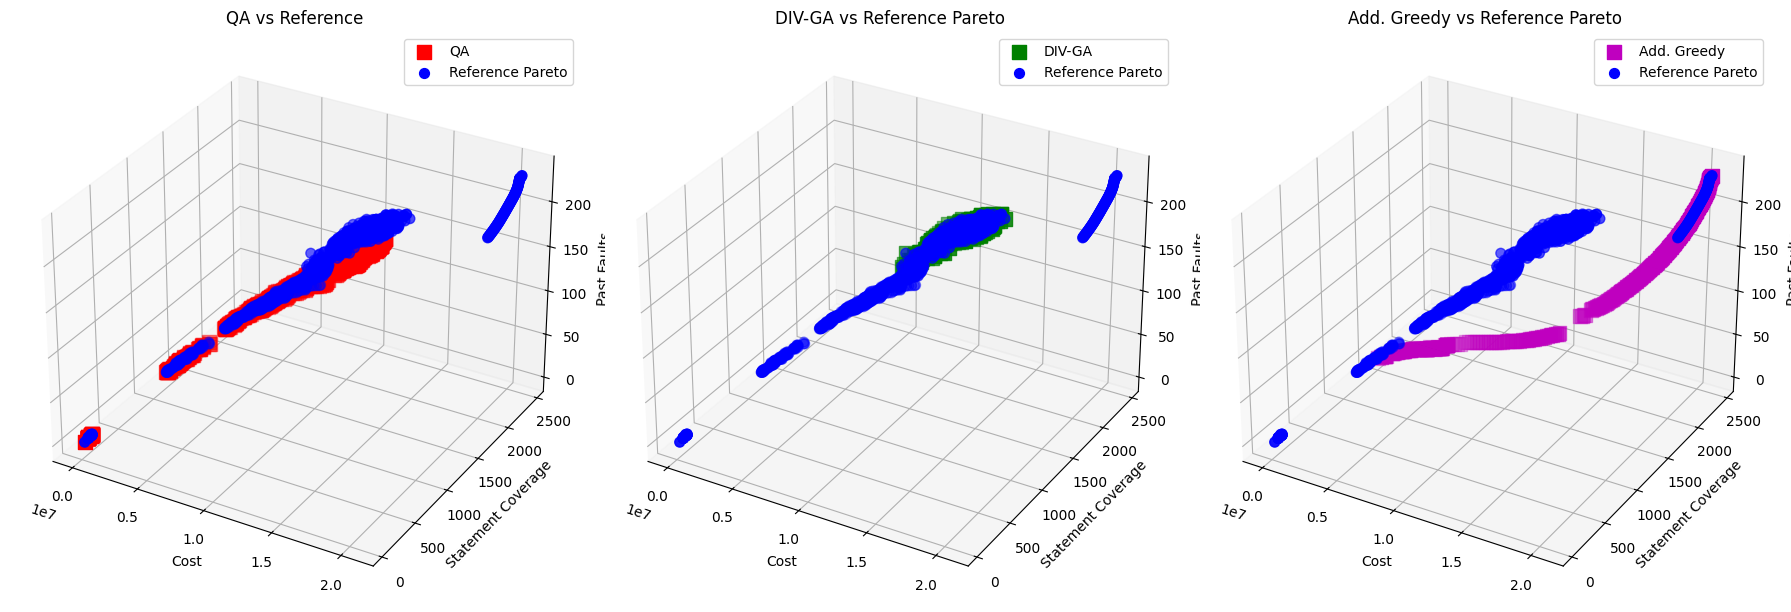

In [38]:
# Unpack the tuples for each list
def unpack_tuples(data):
    return zip(*data)

#qtcs_pareto_vectors,divga_pareto_vectors,greedy_pareto_vectors

x1, y1, z1 = unpack_tuples(qtcs_pareto_vectors)
x2, y2, z2 = unpack_tuples(divga_pareto_vectors)
x3, y3, z3 = unpack_tuples(greedy_pareto_vectors)
x4, y4, z4 = unpack_tuples(reference_pareto)

# Create 3D scatter plots
fig = plt.figure(figsize=(18,6))

# First plot: list1 vs list4
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(x1, y1, z1, c='r', marker='s', s=100, label='QA')
ax1.scatter(x4, y4, z4, c='b', marker='o', s=50, label='Reference Pareto')
ax1.set_xlabel('Cost')
ax1.set_ylabel('Statement Coverage')
ax1.set_zlabel('Past Faults')
ax1.set_title('QA vs Reference')
ax1.legend()

# Second plot: list2 vs list4
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(x2, y2, z2, c='g', marker='s', s=100, label='DIV-GA')
ax2.scatter(x4, y4, z4, c='b', marker='o', s=50, label='Reference Pareto')
ax2.set_xlabel('Cost')
ax2.set_ylabel('Statement Coverage')
ax2.set_zlabel('Past Faults')
ax2.set_title('DIV-GA vs Reference Pareto')
ax2.legend()

# Third plot: list3 vs list4
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(x3, y3, z3, c='m', marker='s', s=100, label='Add. Greedy')
ax3.scatter(x4, y4, z4, c='b', marker='o', s=50, label='Reference Pareto')
ax3.set_xlabel('Cost')
ax3.set_ylabel('Statement Coverage')
ax3.set_zlabel('Past Faults')
ax3.set_title('Add. Greedy vs Reference Pareto')
ax3.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [115]:
#the static values below have been manually stored after each run of the experiments

qtcs_nondom_flex = [194, 194, 193, 193, 194, 189, 194, 189, 188, 187]
div_ga_nondom_flex = [140, 140, 140, 140, 140, 140, 140, 140, 140, 140]
add_greedy_nondom_flex = [205,205,205,205,205,205,205,205,205,205]

qtcs_nondom_grep = [258, 235, 261, 251, 260, 233, 259, 265, 261, 267]
div_ga_nondom_grep = [70, 69, 70, 70, 70, 69, 70, 70, 70, 70]
add_greedy_nondom_grep = [177,177,177,177,177,177,177,177,177,177]

qtcs_nondom_gzip = [67, 66, 69, 31, 69, 32, 64, 33, 35, 35]
div_ga_nondom_gzip = [104, 105, 101, 105, 104, 103, 103, 105, 105, 88]
add_greedy_nondom_gzip = [71,71,71,71,71,71,71,71,71,71]

qtcs_nondom_sed = [104, 123, 110, 105, 110, 110, 115, 101, 107, 99]
div_ga_nondom_sed = [105, 62, 105, 105, 102, 105, 105, 97, 105, 105]
add_greedy_nondom_sed = [80,80,80,80,80,80,80,80,80,80]

lists = [qtcs_nondom_flex,div_ga_nondom_flex,qtcs_nondom_grep,div_ga_nondom_grep,qtcs_nondom_gzip,div_ga_nondom_gzip,qtcs_nondom_sed,div_ga_nondom_sed]

# we are interested in knowing if the obtained sequences are normally distributed to decide what statistical test we should apply
for i, list in enumerate(lists, start=1):
    stat, p_value = shapiro(list)
    print(f"List {i}: Statistic = {stat:.5f}, P-value = {p_value:.5f}")
    
    # check if the sequence is normally distributed (using 0.05 as threshold)
    if p_value > 0.05:
        print(f"List {i} seems to be normally distributed (p-value = {p_value:.5f})")
    else:
        print(f"Lista {i} NOT seems to be normally distributed (p-value = {p_value:.5f})")

List 1: Statistic = 0.79079, P-value = 0.01120
Lista 1 NOT seems to be normally distributed (p-value = 0.01120)
List 2: Statistic = 1.00000, P-value = 1.00000
List 2 seems to be normally distributed (p-value = 1.00000)
List 3: Statistic = 0.80518, P-value = 0.01676
Lista 3 NOT seems to be normally distributed (p-value = 0.01676)
List 4: Statistic = 0.50927, P-value = 0.00000
Lista 4 NOT seems to be normally distributed (p-value = 0.00000)
List 5: Statistic = 0.74031, P-value = 0.00272
Lista 5 NOT seems to be normally distributed (p-value = 0.00272)
List 6: Statistic = 0.56962, P-value = 0.00002
Lista 6 NOT seems to be normally distributed (p-value = 0.00002)
List 7: Statistic = 0.94450, P-value = 0.60408
List 7 seems to be normally distributed (p-value = 0.60408)
List 8: Statistic = 0.47896, P-value = 0.00000
Lista 8 NOT seems to be normally distributed (p-value = 0.00000)


In [122]:
def a12(lst1,lst2,rev=True):
  "how often is x in lst1 more than y in lst2?"
  more = same = 0.0
  for x in lst1:
    for y in lst2:
      if x==y : same += 1
      elif rev and x > y : more += 1
      elif not rev and x < y : more += 1
  return (more + 0.5*same)  / (len(lst1)*len(lst2))

def stat_test(app1, app2):
    statistic, pvalue = mannwhitneyu(app1, app2, alternative='two-sided')

    # Calculate the A12 effect size using Vargha and Delaney's formula
    a12_effect_size = a12(app1, app2)

    return pvalue, a12_effect_size

p_value, a_12 = stat_test(div_ga_nondom_sed,add_greedy_nondom_sed)
print("p_value: " + str(p_value))
print("a12: " + str(a_12))

p_value: 0.001075750661059597
a12: 0.9


In [ ]:
with open('.\\results\\add-greedy\\sed_data.json', 'r') as file:
    pareto_fronts_json = json.load(file)

greedy_execution_time = pareto_fronts_json['resolution_time(ms)']
print(greedy_execution_time)

with open('.\\results\\selectqa\\sed-data.json', 'r') as file:
    pareto_fronts_json = json.load(file)

qtcs_qpu_execution_time = pareto_fronts_json['mean_qpu_run_time(ms)']
qtcs_pareto_building_time = pareto_fronts_json['mean_pareto_fronts_building_time(ms)']
print(qtcs_qpu_execution_time)
print(qtcs_pareto_building_time)

with open('.\\results\\divga\\sed_pareto_fronts_divga.json', 'r') as file:
    pareto_fronts_json = json.load(file)

divga_execution_time = pareto_fronts_json['DIVGA_II_mean_execution_time_ms']
print(divga_execution_time)

## BootQA

BootQA is the first approach to a test case optimization problem using quantum computing. BootQA relies on real-world industrial datasets:

- PaintControl: dataset gathered from ABB Robotics Norway;
- GSDTSR: dataset gathered from Google.

 Each test case in both the datasets has values related to the properties:
 
- "execution time": time needed by the test case to be executed;
- "failure rate": the ability, in percentage, of a test case to spot a failure.

To deal with physical limitations of quantum annealers, BootQA randomly divides the problem into m sub-problems of size n; once it has obtained the m sub-solutions, BootQA merges them into one final solution.

## Evaluation Metrics

To compare SelectQA and BootQA were executed 10 indipendent experiments for each dataset. The resulting suites (10 for each dataset) were directly confronted in terms of "execution time" and "failure rate". The statistical tests used the same methods used for the previous comparisons and were developed in "./BootQA/stats.py".

To compare the efficiency of the two methods, has been use the "QPU Access Time" metric.

In [ ]:
def bootstrap_confidence_interval(data, num_samples, confidence_alpha=0.95):
    """This function determines the statistical range within we would expect the mean value of execution times to fall; it relies on the bootstrapping strategy, which allows the calculation of the confidence interval by repeated sampling (with replacement) from the existing data to obtain an estimate of the confidence interval."""
    sample_means = []
    for _ in range(num_samples):
        bootstrap_sample = [random.choice(data) for _ in range(len(data))]
        sample_mean = np.mean(bootstrap_sample)
        sample_means.append(sample_mean)
    
    lower_percentile = (1 - confidence_alpha) / 2 * 100
    upper_percentile = (confidence_alpha + (1 - confidence_alpha) / 2) * 100
    lower_bound = np.percentile(sample_means, lower_percentile)
    upper_bound = np.percentile(sample_means, upper_percentile)
    
    return lower_bound, upper_bound

In [ ]:
def create_linear_bqm(test_cases_costs,test_cases_rates,alpha):
    """This function is the one that has to encode the QUBO problem that the D-Wave Hybrid Sampler will have to solve. The QUBO problem specifies the optimization to solve and a quadratic binary unconstrained problem"""
    qubo = dimod.AdjVectorBQM(dimod.BINARY)
    
    max_cost = max(test_cases_costs)

    #linear coefficients, that are the diagonal of the matrix encoding the QUBO
    for i in range(len(test_cases_costs)):
        cost = (alpha * ((test_cases_costs[i])/max_cost)) - ((1-alpha)*test_cases_rates[i])
        qubo.set_linear(i, cost)

    return qubo

In [ ]:
bootqa_programs = ["gsdtsr","paintcontrol"]
bootqa_alphas = {"gsdtsr": 0.98,"paintcontrol": 0.90}
run_times_dictionary = {"gsdtsr": [],"paintcontrol": []}
sampler = LeapHybridSampler(token="",qpu=True)

def get_data(data_name):
    data = pd.read_csv("BootQA/"+data_name+"/"+data_name+".csv", dtype={"time": float, "rate": float})
    #I just consider data with failure rate > 0 (because it means they found at least 1 fault)
    data = data.drop(data[data['rate'] == 0].index)
    #this way every case has 1 as bool failure value
    return data

for bootqa_program in bootqa_programs:
    final_test_suite_costs = []
    final_failure_rates = []
    for _ in range(tot_run):
        data = get_data(bootqa_program)
        test_cases_costs = data["time"].tolist()
        test_cases_rates = data["rate"].tolist()
        linear_bqm = create_linear_bqm(test_cases_costs, test_cases_rates, bootqa_alphas[bootqa_program])
        #for each iteration get the result
        response = sampler.sample_qubo(linear_bqm.to_numpy_matrix())
        run_times_dictionary[bootqa_program].append(response.info['qpu_access_time'])
        
        first_sample_dictionary = {i: response.samples()[0][i] for i in range(len(response.samples()[0]))}
    
        #make a list with only the ids of test cases selected by the final solution
        final_selected_cases = [id for id, value in first_sample_dictionary.items() if value == 1]
        
        #compute the final test suite cost
        final_test_suite_cost = 0
        for selected_test_case in final_selected_cases:
            final_test_suite_cost += test_cases_costs[selected_test_case]
        final_test_suite_costs.append(final_test_suite_cost)
            
        #compute the total failure rate
        final_failure_rate = 0
        for selected_test_case in final_selected_cases:
            final_failure_rate += test_cases_rates[selected_test_case]
        final_failure_rates.append(final_failure_rate)
    
    #compute the qpu access times
    qpu_run_times_without_zeros = []
    for access_time in run_times_dictionary[bootqa_program]:
      if access_time != 0:
        qpu_run_times_without_zeros.append(access_time)
    lower_bound, upper_bound = bootstrap_confidence_interval(qpu_run_times_without_zeros, 1000, 0.95)
    for i in range(len(run_times_dictionary[bootqa_program])):
      if run_times_dictionary[bootqa_program][i] == 0:
          run_times_dictionary[bootqa_program][i] = upper_bound
    average_qpu_access_time = statistics.mean(run_times_dictionary[bootqa_program]) 
    
    var_names = ["final_test_suite_costs", "final_failure_rates",
                 "average_qpu_access_time(ms)", "qpu_lower_bound(ms)", "qpu_upper_bound()"]
    values = [final_test_suite_costs, final_failure_rates, average_qpu_access_time, lower_bound, upper_bound]
    
    with open("BootQA/"+bootqa_program+"/sum.csv", "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(var_names)
        writer.writerow(values)